# **Importing Dependencies**

In [164]:
import os
from typing import Any
import nltk
import nltk.internals
import pandas as pd

In [165]:
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

# **Loading the Interviews and Pre-Processing them**


## **Reading interviews from text files**

In [1]:
# interviews =[]
# for i in range(9):
#     with open(f"Deidentified_parents_interview_{i+1}.txt", "r", encoding='utf8') as fp:
#         interview = fp.read()
#         interviews.append(interview)
# interviews

In [167]:
for i in range(9):
    print(len(interviews[i].split()))

11688
12575
11774
11457
11115
10908
8936
12664
7767


## **Splitting text into smaller chunks**

In [168]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 800000,
    separators=["\n\n","\n", "Interviewer"],
    length_function=len,
    is_separator_regex=False
)

In [169]:
collection=[]
for interview in interviews:
    doc = text_splitter.create_documents([interview])
    collection.append(doc)

In [170]:
def format_docs(collection):
    texts=[]
    for docs in collection:
        for doc in docs:
            texts.append(doc.page_content)
    return texts

texts = format_docs(collection)

In [2]:
# texts

# **Extracting codes from the interviews**

In [172]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

In [173]:
class Themes(BaseModel):
    Name: str
    Description: str
    Quote: str

parser = JsonOutputParser(pydantic_object=Themes)

In [174]:
open_api_key = ""
os.environ["OPENAI_API_KEY"]=open_api_key
# model_name = "gpt-4o"
model_name = "gpt-4o-mini"
model = ChatOpenAI(model_name = model_name, temperature = 1)

In [176]:
prompt_text = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual

### User:
Identify all themes in the text, provide a name for each theme in no more than 5 words, a condensed description of the theme, and a quote from the interview that supports the theme.

Format the response as a JSON output keeping names, descriptions and quotes together in the JSON, and keep them together in 'Themes'.
The response should start from 'Themes' as a JSON output
text: {text}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

LLMchain = {"text": lambda x:x} | prompt | model | parser

In [177]:
themes = LLMchain.batch(texts, {"max_concurrency": 20})

In [188]:
themes

[{'Themes': [{'name': 'Understanding Heart Conditions',
    'description': "Participants share how they refer to and understand their children's heart conditions.",
    'quote': 'We usually refer to it as anomalous right coronary artery.'},
   {'name': 'Emotional Toll on Parents',
    'description': "The anxiety and stress parents experience regarding their child's condition and care.",
    'quote': "I think we're always walking on eggshells because there's not enough information."},
   {'name': 'Decision-Making Challenges',
    'description': 'Difficulties in making decisions about treatment and surgery for their children.',
    'quote': "It's like a flipping of a coin situation."},
   {'name': 'Searching for Information',
    'description': "The struggle to find accurate and helpful information regarding their children's heart conditions.",
    'quote': 'The lack of information for parents, for me and for my husband, has been really hard.'},
   {'name': 'Support Systems',
    'descri

In [179]:
# collections = [parser.invoke(theme)['Themes'] for theme in themes]
collections = [theme['Themes'] for theme in themes]
list_of_codes = []
for codes in collections:
    for code in codes:
        list_of_codes.append(code)

In [180]:
df_codes = pd.DataFrame(columns=['Code','Description','Quote'])
for i,code in enumerate(list_of_codes):
        df_codes.loc[i,'Code'] = code.get('name') or code.get('Name')
        df_codes.loc[i,'Description'] = code.get('description') or code.get('Description')
        df_codes.loc[i,'Quote'] = code.get('quote') or code.get('Quote')

df_codes

,Code,Description,Quote
0,Understanding Heart Conditions,Participants share how they refer to and under...,We usually refer to it as anomalous right coro...
1,Emotional Toll on Parents,The anxiety and stress parents experience rega...,I think we're always walking on eggshells beca...
2,Decision-Making Challenges,Difficulties in making decisions about treatme...,It's like a flipping of a coin situation.
3,Searching for Information,The struggle to find accurate and helpful info...,"The lack of information for parents, for me an..."
4,Support Systems,The importance of having a supportive communit...,Getting a good support system is good.
...,...,...,...
76,Desire for Support and Community,Parents express a need for community support t...,It would be nice to know other parents who are...
77,Professional Care Relationships,The quality of interaction with healthcare pro...,"When I was at the second opinion hospital, I w..."
78,Living in Uncertainty,Parents struggle with the unpredictability and...,"It's the unknown is just really hard, that no ..."
79,Advocacy and Information Seeking,Parents emphasize the importance of being proa...,"The more information you have, the better."


In [ ]:
# for desc in df_codes['Description'][:5].tolist():
#     print(desc)

In [181]:
# get a time stamp for the file name
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_codes.to_csv(f"df_codes_parents_baseline_{now}_{model_name}.csv", index=False)

In [ ]:
# df_codes = pd.read_csv("C://Users/MRaza845/Documents/gpt4all_chatbot/ThematicAnalysis/Data/Parents_version_1/df_codes_parents.csv")
# df_codes

## **Finding major themes from the unique codes**

In [182]:
class Groups(BaseModel):
    Group: str
    Description: str
    # Original_Topics: list[str]
    
parser = JsonOutputParser(pydantic_object=list[Groups])

In [183]:
# Prompt for generating initial themes from each chunk
chunk_prompt_template = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual.
### User:
Determine how all the topics in the list of topics can be grouped together. Topics can be in more than one group. Provide a name and description for each group.

Format the response as a JSON output, keeping Name and Description under 'Groups' together in the JSON.

text = {text}
"""
chunk_prompt = ChatPromptTemplate.from_template(chunk_prompt_template)

In [197]:
# Function to format data for the prompt
def format_dataframe(df):
    text = ""
    for _, row in df.iterrows():
        text += f"Topics: {row['Code']}, Description: {row['Description']}\n"
    return text

# Step 1: Split data into chunks
chunk_size = 1000  # Adjust based on input length limits and complexity
chunks = [df_unique_codes[i:i + chunk_size] for i in range(0, len(df_unique_codes), chunk_size)]

In [185]:
chunks_3 = chunks * 3

In [186]:
# Step 2: Process each chunk independently to gather preliminary themes
all_initial_themes = []
for chunk in chunks_3:
    text = format_dataframe(chunk)
    # Process each chunk to generate preliminary themes
    response = chunk_prompt | model | parser
    chunk_themes = response.invoke({"text": text}, max_concurrency=20)
    print(chunk_themes)

    if isinstance(chunk_themes, dict) and "Groups" in chunk_themes:
        chunk_themes = chunk_themes["Groups"]
        all_initial_themes.append(chunk_themes)
    elif isinstance(chunk_themes, dict) and "groups" in chunk_themes:
        chunk_themes = chunk_themes["groups"]
        all_initial_themes.append(chunk_themes)
    else:
        print("Unexpected response format:", chunk_themes)
        all_initial_themes.append(chunk_themes)

{'Groups': [{'Name': 'Communication Challenges', 'Description': 'This group encompasses the difficulties faced in communicating about heart conditions both within families and with healthcare providers, reflecting the need for clearer communication, consistent terminology, and educational conversations.'}, {'Name': 'Emotional and Psychological Impact', 'Description': 'This group focuses on the emotional turmoil, anxiety, and concerns experienced by parents and children related to heart conditions, highlighting the significance of mental health support and the psychological effects on families.'}, {'Name': 'Support Networks and Community', 'Description': 'This group highlights the importance of having support systems and community connections for emotional and informational backing, fostering shared experiences, and reducing feelings of isolation.'}, {'Name': 'Decision-Making and Information Seeking', 'Description': 'This group emphasizes the challenges parents face in making informed m

In [187]:
# groups = [group for sublist in all_initial_themes for group in parser.invoke(sublist)['Groups']]
groups = [group for sublist in all_initial_themes for group in sublist]

for group in groups:
    print(group)

{'Name': 'Communication Challenges', 'Description': 'This group encompasses the difficulties faced in communicating about heart conditions both within families and with healthcare providers, reflecting the need for clearer communication, consistent terminology, and educational conversations.'}
{'Name': 'Emotional and Psychological Impact', 'Description': 'This group focuses on the emotional turmoil, anxiety, and concerns experienced by parents and children related to heart conditions, highlighting the significance of mental health support and the psychological effects on families.'}
{'Name': 'Support Networks and Community', 'Description': 'This group highlights the importance of having support systems and community connections for emotional and informational backing, fostering shared experiences, and reducing feelings of isolation.'}
{'Name': 'Decision-Making and Information Seeking', 'Description': 'This group emphasizes the challenges parents face in making informed medical decision

In [205]:
# Step 3: reflect
consolidation_prompt_template = """
### System: You are a professional sociologist, when you read the text you recognize themes and relationships. When asked to compare concepts you are able to recognize connections that are abstract or conceptual.
### User:
Given the following list of topics,
Topics: {topic_text}

Determine how all the topics in the list of topics can be grouped together. Topics can be in more than one group. Provide a name and description for each group.

themes_text = {themes_text}

You are a resolver tasked with finding the answers that best determines how all the topics in the list of topics can be grouped together.Removing any redundant or duplicate answers.
Let's work this one out in a step by step way:

Give 12 groups that best represent the topics.
Format the response as a JSON output with major groups, each containing the name and Description.
"""
consolidation_prompt = ChatPromptTemplate.from_template(consolidation_prompt_template)

In [206]:
# Prepare input for the consolidation step
themes_text = "\n".join([f"Theme: {theme['Name']}, Description: {theme['Description']}" for 
                                sublist in all_initial_themes for theme in sublist])

In [207]:
topic_text = format_dataframe(df_codes)
topic_text

"Topics: Understanding Heart Conditions, Description: Participants share how they refer to and understand their children's heart conditions.\nTopics: Emotional Toll on Parents, Description: The anxiety and stress parents experience regarding their child's condition and care.\nTopics: Decision-Making Challenges, Description: Difficulties in making decisions about treatment and surgery for their children.\nTopics: Searching for Information, Description: The struggle to find accurate and helpful information regarding their children's heart conditions.\nTopics: Support Systems, Description: The importance of having a supportive community and emotional support.\nTopics: Struggles with Communication, Description: Challenges in discussing the condition with family, friends, and their children.\nTopics: Coping with Uncertainties, Description: Managing the unknowns and unpredictability of their children's health journey.\nTopics: Advocacy for Better Awareness, Description: Desire for increased 

In [208]:
consolidation_text

"Theme: Emotional Challenges, Description: Exploration of the emotional turmoil and anxiety faced by parents due to their child's heart condition, highlighting the need for mental health support and coping mechanisms.\nTheme: Communication Issues, Description: Focus on the difficulties in communicating about the child's health condition, including the need for clarity from medical professionals and effective communication strategies with family and patients.\nTheme: Decision-Making and Guidance, Description: Challenges parents encounter in making informed healthcare decisions, including the desire for better medical guidance, the importance of second opinions, and the burden of decision-making.\nTheme: Support and Community, Description: The importance of strong support systems, including connections with other families facing similar challenges, and the role of emotional and informational backing in managing healthcare.\nTheme: Managing Uncertainty, Description: Parents grapple with t

In [209]:
# Create final prompt for consolidation
final_response = consolidation_prompt | model | parser
final_themes = final_response.invoke({"topic_text": topic_text, "themes_text": themes_text}, max_concurrency=20)

In [211]:
final_themes

{'groups': [{'name': 'Communication Challenges',
   'description': 'This group encompasses the difficulties faced in communicating about heart conditions both within families and with healthcare providers, reflecting the need for clearer communication, consistent terminology, and educational conversations.'},
  {'name': 'Emotional and Psychological Impact',
   'description': 'This group focuses on the emotional turmoil, anxiety, and concerns experienced by parents and children related to heart conditions, highlighting the significance of mental health support and the psychological effects on families.'},
  {'name': 'Support Networks and Community',
   'description': 'This group highlights the importance of having support systems and community connections for emotional and informational backing, fostering shared experiences, and reducing feelings of isolation.'},
  {'name': 'Decision-Making and Information Seeking',
   'description': 'This group emphasizes the challenges parents face in

In [212]:
# parser = JsonOutputParser(pydantic_object=list[Groups])
# final_themes = parser.invoke(final_themes)

In [213]:
final_themes

{'groups': [{'name': 'Communication Challenges',
   'description': 'This group encompasses the difficulties faced in communicating about heart conditions both within families and with healthcare providers, reflecting the need for clearer communication, consistent terminology, and educational conversations.'},
  {'name': 'Emotional and Psychological Impact',
   'description': 'This group focuses on the emotional turmoil, anxiety, and concerns experienced by parents and children related to heart conditions, highlighting the significance of mental health support and the psychological effects on families.'},
  {'name': 'Support Networks and Community',
   'description': 'This group highlights the importance of having support systems and community connections for emotional and informational backing, fostering shared experiences, and reducing feelings of isolation.'},
  {'name': 'Decision-Making and Information Seeking',
   'description': 'This group emphasizes the challenges parents face in

In [214]:
collections = final_themes['groups']
df_themes = pd.DataFrame(columns=['Theme','Description'])
for i,theme in enumerate(collections):
    df_themes.loc[i,'Theme'] = theme['name']
    df_themes.loc[i,'Description'] = theme['description']

df_themes

,Theme,Description
0,Communication Challenges,This group encompasses the difficulties faced ...
1,Emotional and Psychological Impact,"This group focuses on the emotional turmoil, a..."
2,Support Networks and Community,This group highlights the importance of having...
3,Decision-Making and Information Seeking,This group emphasizes the challenges parents f...
4,Future Concerns and Uncertainty,This group captures the anxieties regarding th...
5,Adapting to New Realities,This group includes the adjustments families m...
6,Parental Responsibilities and Advocacy,This group reflects the responsibilities of pa...
7,Navigating the Healthcare System,This group encompasses the experiences familie...
8,Educational and Informational Needs,Highlighting the need for better understanding...
9,Coping Mechanisms and Resilience,This group revolves around how families adapt ...


In [215]:
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
df_themes.to_csv(f"df_themes_parents_baseline_{now}_{model_name}_long.csv", index=False)

## **Comparison with annotated themes developed by humans**

In [216]:
with open("AAOCA_Parents_outcomes_themes.txt",
          encoding='utf8') as fp:
    human_themes = fp.read()

In [217]:
with open("AAOCA_Parents_outcomes.txt",
          encoding='utf8') as fp:
    human_themes_description = fp.read()

In [218]:
human_themes_split = human_themes.split('\n\n')
descriptions_split = human_themes_description.split("\n\n")

In [219]:
df_human_themes = pd.DataFrame(columns=['Theme','Description', 'Codes'])
for i,theme in enumerate(human_themes_split):
    theme_split = theme.split(':')
    df_human_themes.loc[i,'Codes'] = theme_split[1].split('\n')[1:]

In [220]:
# length = 0
# for codes in df_themes['Original_Codes']:
#     length += len(codes)

# length

In [221]:
indexes = [11,6,10,1,4,5,8,2,7,0,9,3]

In [222]:
for i,(ind,description) in enumerate(zip(indexes,descriptions_split)):
    description_split = description.split(":\n")
    # print(description_split)
    df_human_themes.loc[ind, 'Theme']=description_split[0]
    df_human_themes.loc[ind, 'Description']=description_split[1]

In [223]:
df_human_themes

,Theme,Description,Codes
0,Clarity of potential risks and outcomes,While acknowledging the current challenges of ...,"[Fear of cardiac events, Uncertainty of future..."
1,Freedom from hypervigilance related to the con...,A dominating sense of hypervigilance was descr...,"[Fear of cardiac events, Parents always on, Un..."
2,The diagnosis given in a compassionate and emp...,While the diagnosis experience was minimally d...,"[Diagnosis as traumatic and frightening, Diagn..."
3,A sense of control over the future,Receiving the diagnosis of AAOCA for their chi...,"[Lack of control over outcomes for child, Unce..."
4,Being heard and taken seriously by clinicians,"As with individuals with AAOCA, parents expres...",[Frequent challenges within the diagnostic jou...
5,Individualized support for management decision...,Similar to individuals with a diagnosis of AAO...,"[Decision between intervention and limitation,..."
6,Receiving support from others,"As in individuals with a diagnosis of AAOCA, p...",[Importance of support from family and friends...
7,Being appropriately informed,Parents also endorsed the importance of feelin...,"[Searching for answers on own, Trying to under..."
8,Partnership with the care team,Being a partner with the care team was also im...,[Importance of clinician relationships and int...
9,Feeling that my child is safe,Their child’s safety was of great importance t...,"[Planning for adverse events, Parents always o..."


In [224]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util

# Evaluation

# all-mpnet-base-v2

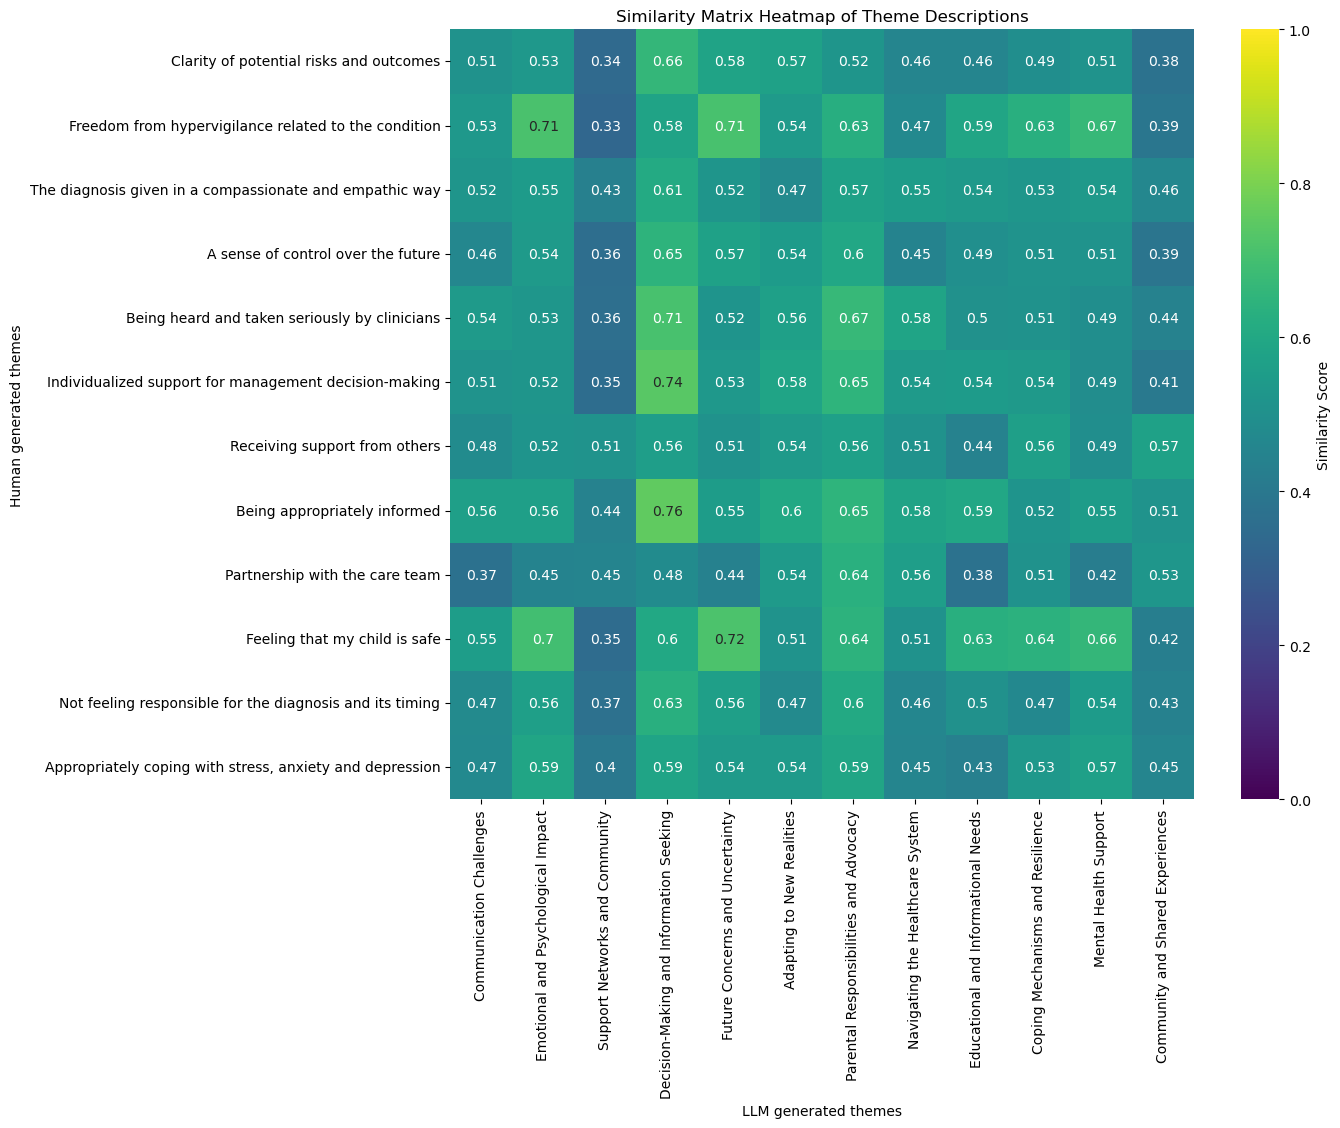

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name_eval = "all-mpnet-base-v2"
model = SentenceTransformer('all-mpnet-base-v2')

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [226]:
import numpy as np
threshold = np.quantile(similarity_desc_df, 0.80)
threshold

0.5875104427337646

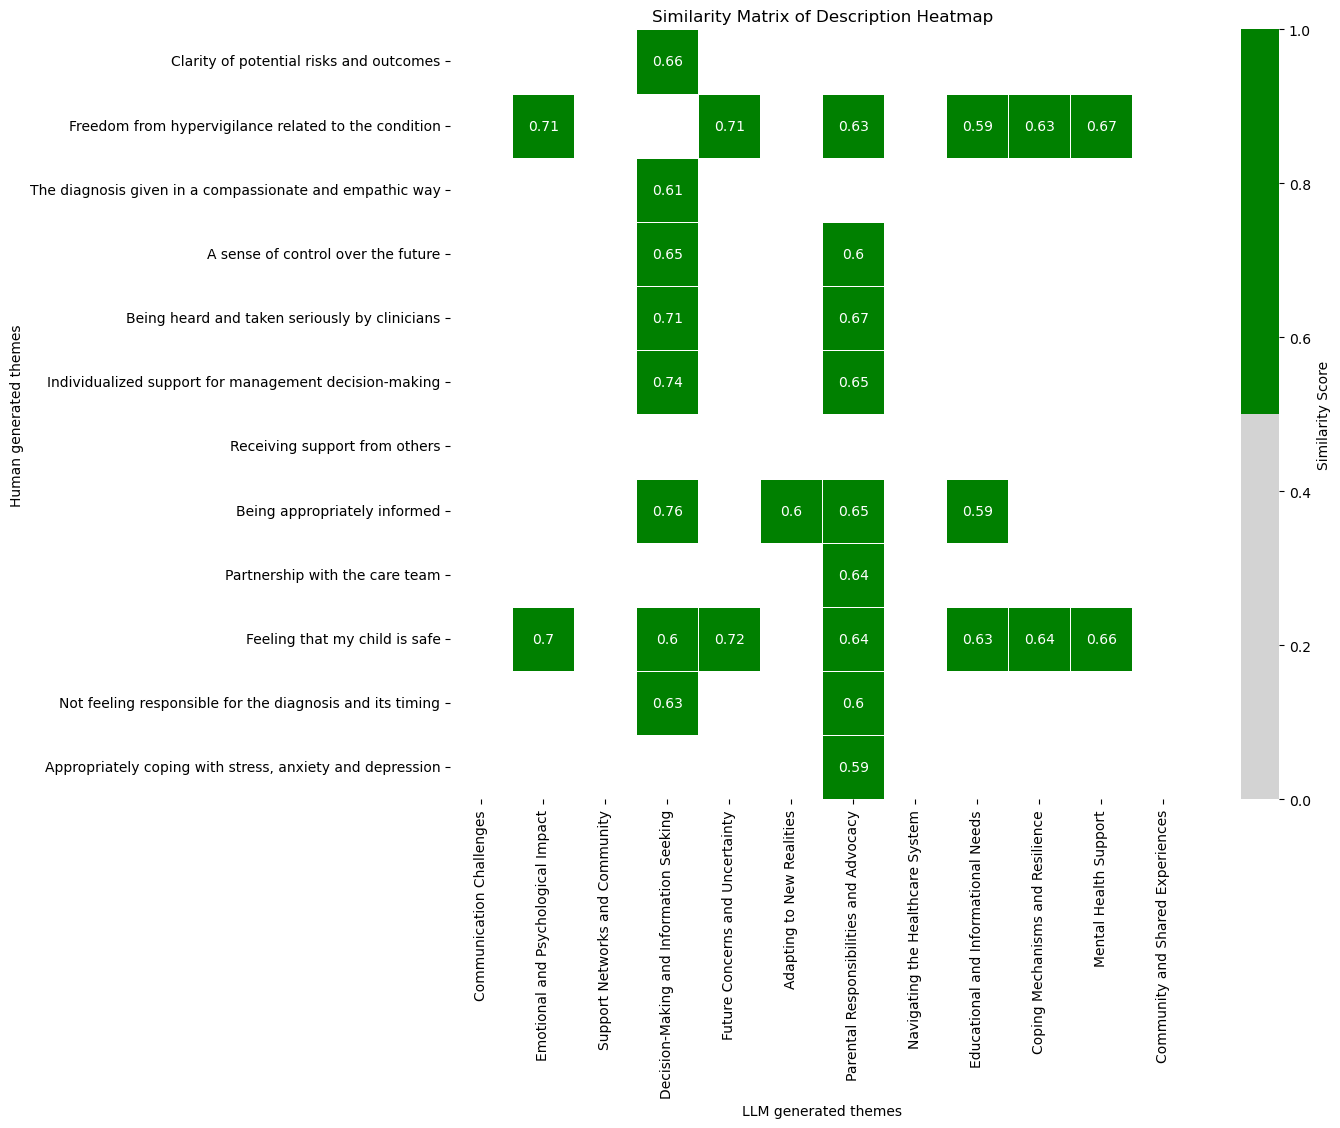

In [227]:
from matplotlib.colors import ListedColormap

threshold = np.quantile(similarity_desc_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [228]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= .6198)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= .6198, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-mpnet-base-v2 Threshold: 0.59
Jarcard. 0.146
Hit Rate. 0.75


# all-MiniLM-L6-v2

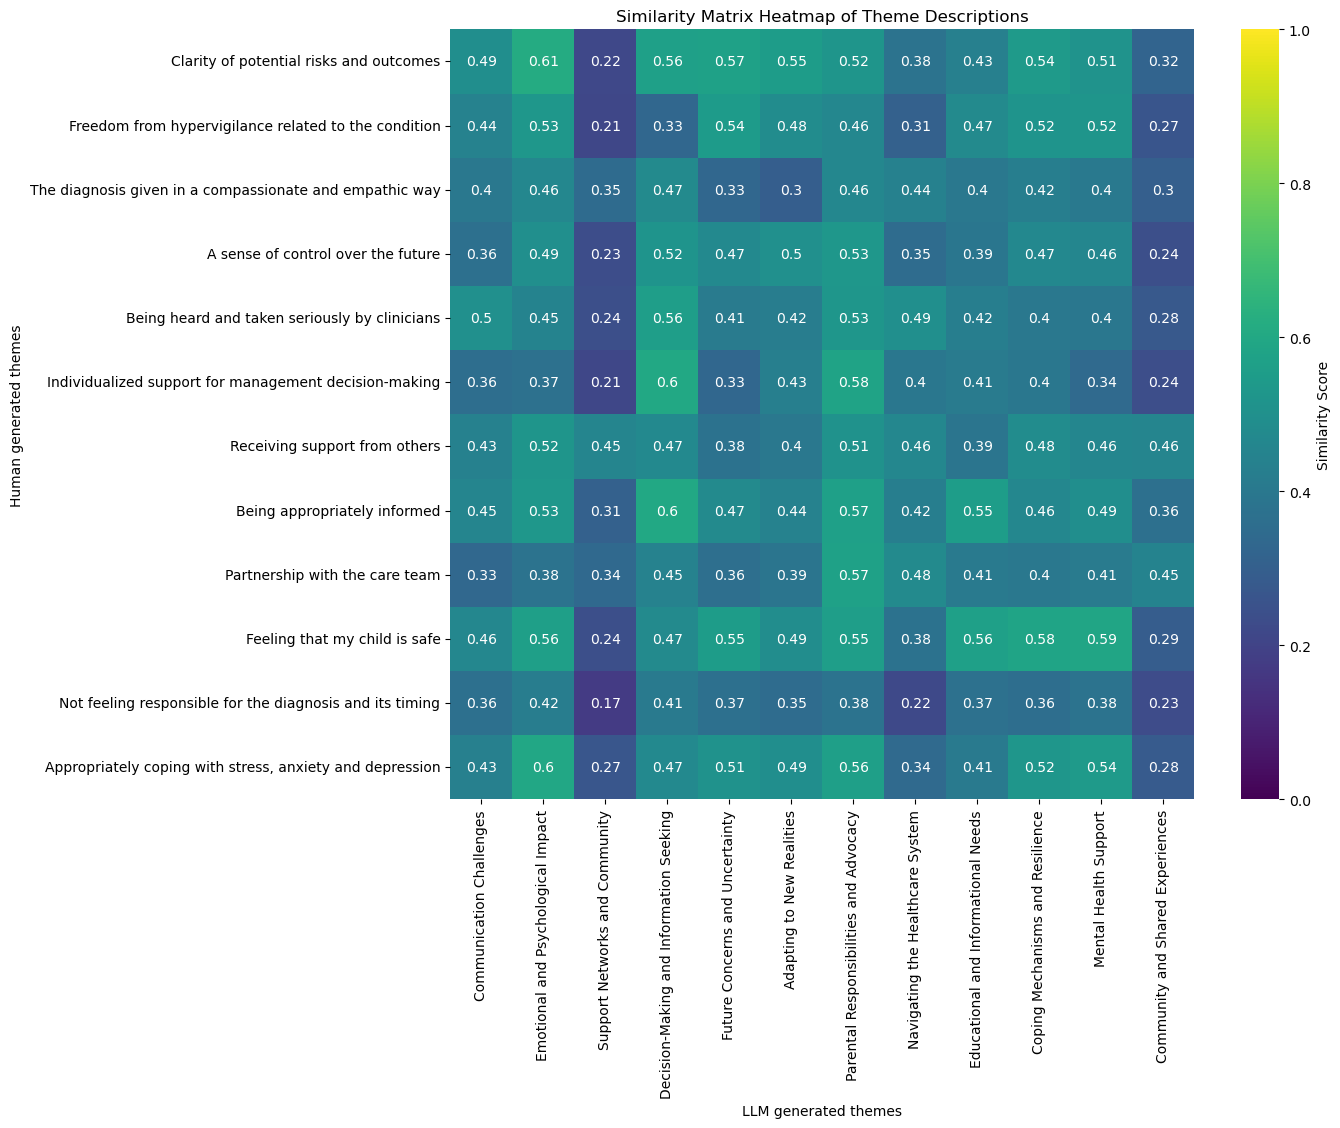

In [229]:
model_name_eval = "all-MiniLM-L6-v2"
model = SentenceTransformer('all-MiniLM-L6-v2')

human_desc_embeddings = model.encode(df_human_themes['Description'].tolist(), convert_to_tensor=True)
llm_desc_embeddings = model.encode(df_themes['Description'].tolist(), convert_to_tensor=True)

cosine_sim_matrix = util.pytorch_cos_sim(human_desc_embeddings,llm_desc_embeddings).numpy()

similarity_desc_df = pd.DataFrame(
    cosine_sim_matrix,
    index = df_human_themes['Theme'],
    columns = df_themes['Theme']
)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

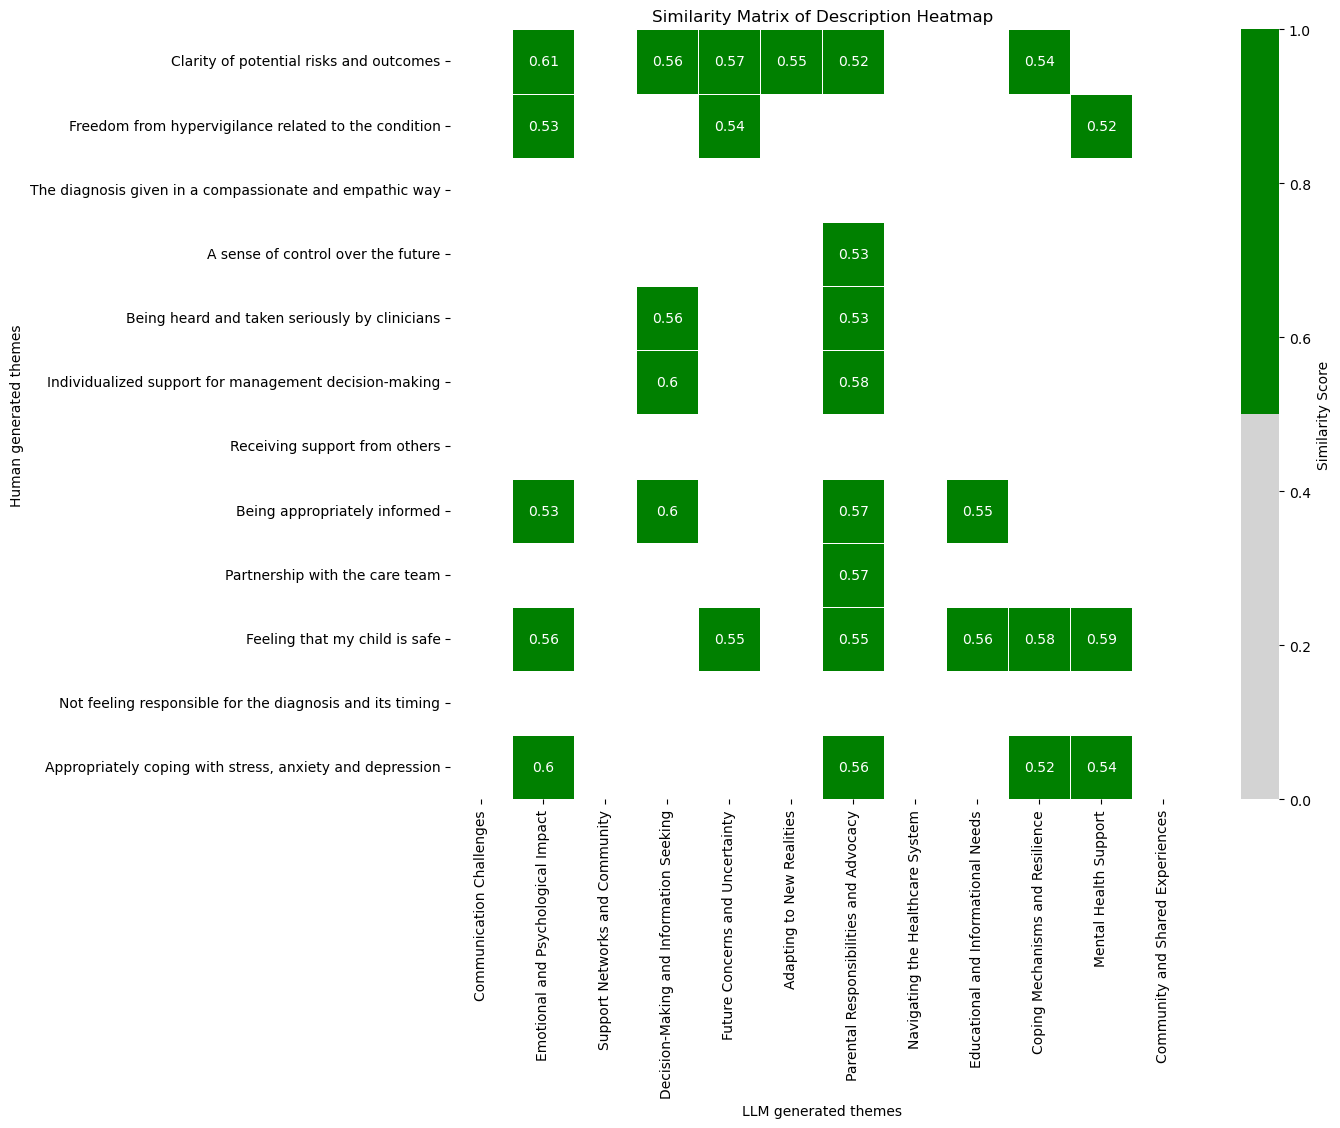

In [230]:
threshold = np.quantile(similarity_desc_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_desc_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_desc_df <= threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [231]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_desc_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= 0.5627)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_desc_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= 0.5627, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

all-MiniLM-L6-v2 Threshold: 0.52
Jarcard. 0.083
Hit Rate. 0.5


## **LLM Based Evaluation**

In [232]:
def format_rows(llm_row, human_row):
    text = ""
    text += f"LLM Theme: {llm_row['Theme']}, LLM Description: {llm_row['Description']}, Human Theme: {human_row['Theme']}, Human Description: {human_row['Description']} "

    return text

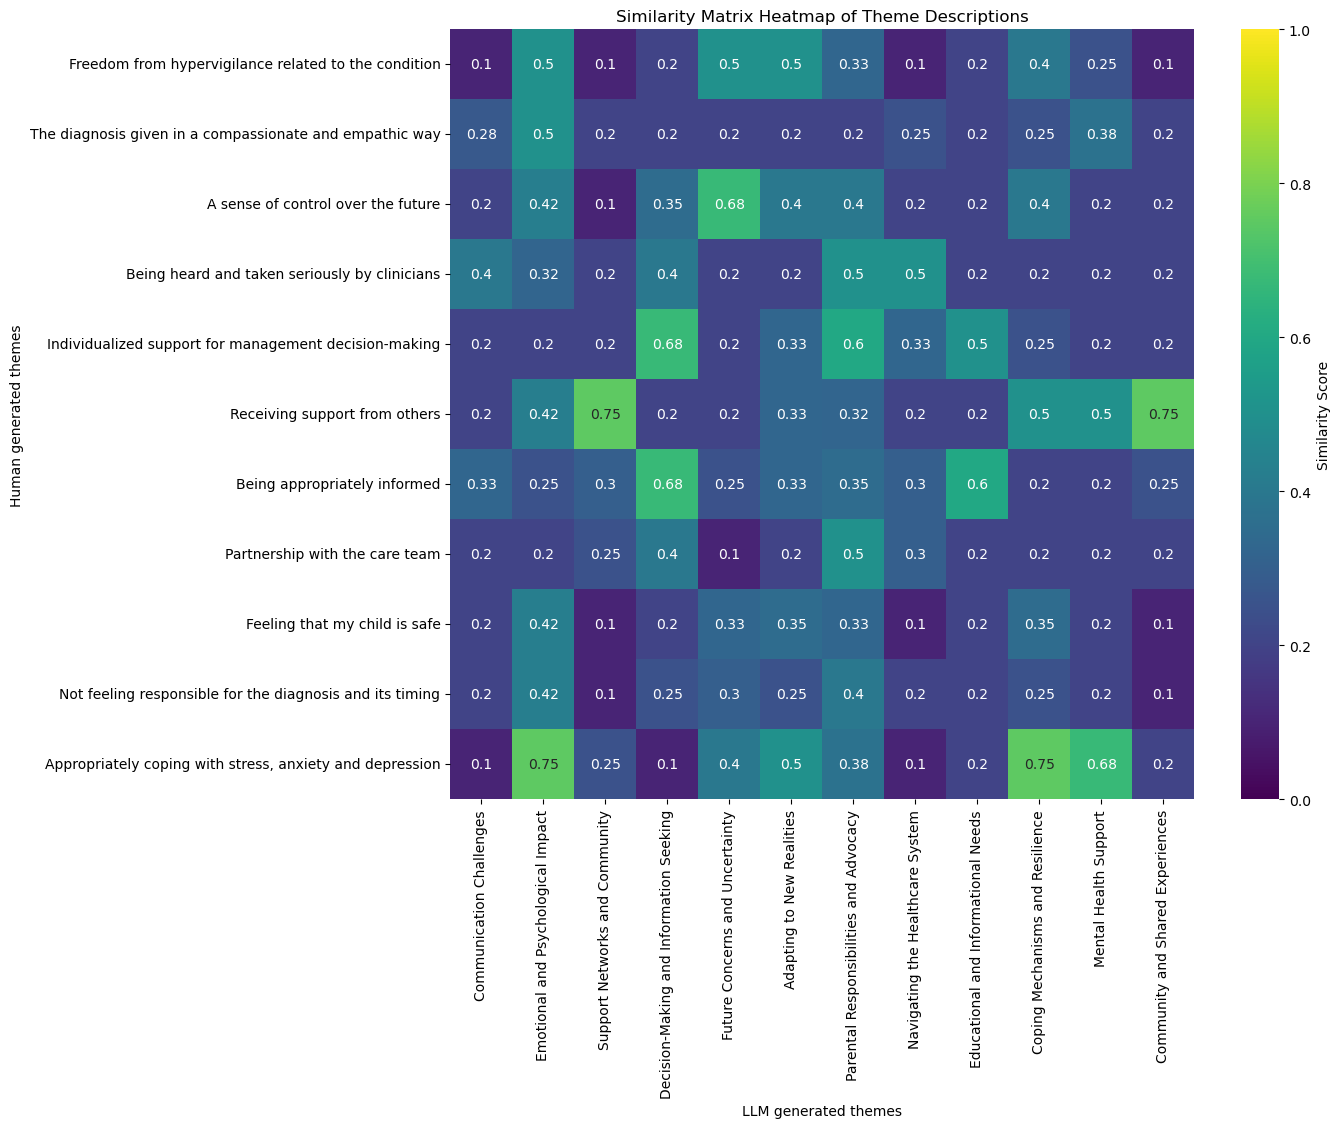

In [233]:
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

model_name_eval = "GPT-4o-mini"


open_api_key = ""
import os
os.environ["OPENAI_API_KEY"]=open_api_key
model_name = "gpt-4o-mini"

model = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)
parser = StrOutputParser()
prompt_template = """
You are a qualitative research expert performing inductive theme analysis.
Your goal is to evaluate the similarity between two theme pairs based on their names and descriptions provided in the text.
Carefully consider any overlapping concepts, keywords, ideas and the specificity when determining the similarity rating.
If one theme is very broad and the other is very specific, give some penalty to the similarity score.
Rate the similarity on a scale from 0 to 1, where 1 means they are identical and 0 means they are completely different.
text: {text}

For the output just give the similarity score as a number rounded to 3 decimals and nothing else.
Similarity Score:
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
LLMchain = prompt | model | parser
similarity_matrix_llm = pd.DataFrame(index=df_human_themes['Theme'], columns=df_themes['Theme'])
for i, llm_row in df_human_themes.iterrows():
    for j, human_row in df_themes.iterrows():
        text = format_rows(llm_row, human_row)
        response = LLMchain.invoke({"text": text})
        similarity_score = float(response)
        similarity_matrix_llm.at[llm_row['Theme'], human_row['Theme']] = similarity_score
similarity_llm_df=similarity_matrix_llm.iloc[1:,:].astype(float)
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap="viridis", vmin=0, vmax=1, cbar_kws={'label':'Similarity Score'})
plt.title('Similarity Matrix Heatmap of Theme Descriptions')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

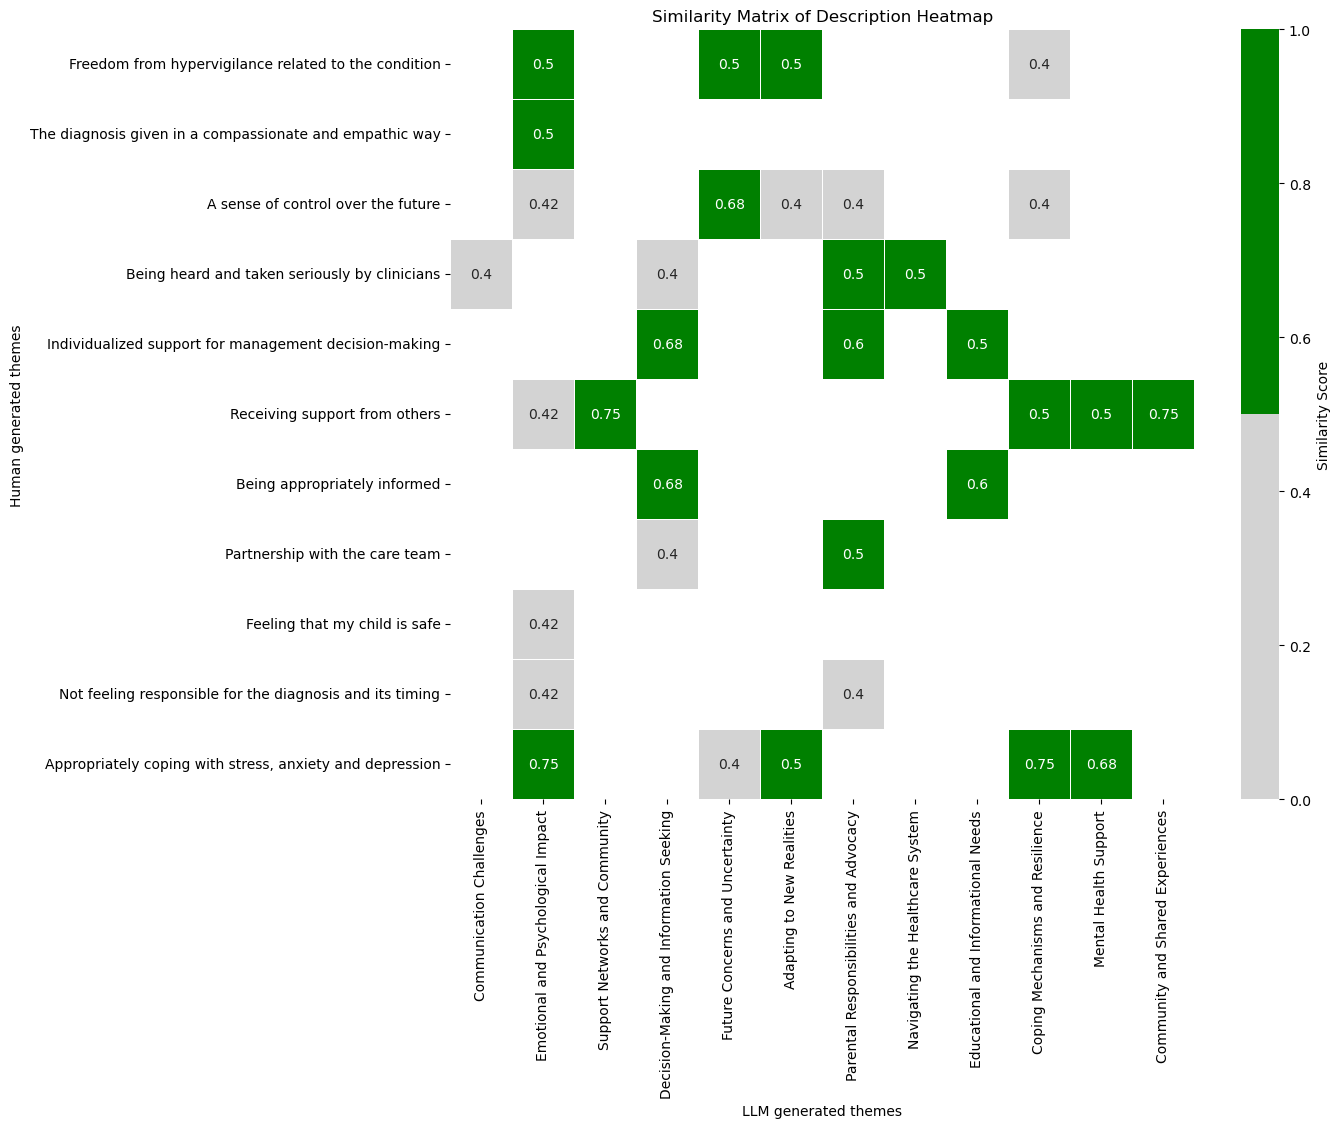

In [234]:
from matplotlib.colors import ListedColormap
threshold = np.quantile(similarity_llm_df, 0.80)
cmap = ListedColormap(["lightgray","Green"])
plt.figure(figsize = (12,10))
sns.heatmap(similarity_llm_df, annot=True, cmap=cmap, vmin=0, vmax=1, mask= (similarity_llm_df < threshold),
            cbar_kws={'label':'Similarity Score'}, linewidths=0.5)
plt.title('Similarity Matrix of Description Heatmap')
plt.xlabel('LLM generated themes')
plt.ylabel('Human generated themes')
plt.show()

In [236]:
print(f'{model_name_eval} Threshold: {round(threshold,2)}')
similarity_array = similarity_llm_df.to_numpy()
total_cells = similarity_array.size
high_similarity_count = np.sum(similarity_array >= .5)
percent_high = (high_similarity_count/total_cells)
print(f"Jarcard. {round(percent_high,3)}")

similarity_array = similarity_llm_df.to_numpy()
total_hit = np.sum(np.any(similarity_array >= .5, axis=1).astype(int))
hit_rate = total_hit/len(df_human_themes)
print(f"Hit Rate. {round(hit_rate,3)}")

GPT-4o-mini Threshold: 0.4
Jarcard. 0.159
Hit Rate. 0.75
